In [1]:
import json

from climateforcing.utils import mkdir_p
import fair
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.stats as st

import xarray as xr
from itertools import product

# Reproducible figures
np.random.seed(42)

## Load up saved output

In [2]:
df_in = {}
for var in ['temperature', 'ERFaer']:
    df_in[var] = pd.read_csv('../data_output/fair_{}/ssp126.csv'.format(var), index_col='year')

with open('../data_input/ar6-fair-samples/fair-1.6.2-wg3-params-slim-reconstrained.json') as f:
    config_list_variable = json.load(f)
    
def get_ecs(cfg):
    return(cfg['F2x']/cfg['lambda_global'])

n_ens = df_in['temperature'].shape[1]
n_ens

ecs = np.zeros(n_ens)
for i, cfg in enumerate(config_list_variable):
    ecs[i] = get_ecs(cfg)
    

In [3]:
ERFaer_PD = df_in['ERFaer'].loc[2005.5:2014.5,:].mean(axis=0)
erf_da = xr.DataArray(ERFaer_PD, coords=[('member', np.arange(n_ens))])
aer_minus1_lb = erf_da>-1

ecs_da = xr.DataArray(ecs, coords=[('member', np.arange(n_ens))])

t_2050_da = xr.DataArray(df_in['temperature'].loc[2050.5, :], coords=[('member', np.arange(n_ens))])
t_2100_da = xr.DataArray(df_in['temperature'].loc[2100.5, :], coords=[('member', np.arange(n_ens))])


## Characterise by aerosol forcing

In [4]:
n_scalings = 5
n_shifts = 5
scalings = np.logspace(0., -1., n_scalings)
shifts = np.linspace(-1.5, -0.4, n_shifts)

In [5]:

def _is_valid(shift_scale):
    # TODO: It might be useful to add some sort of bootstrapping here for uncertainty estimates
    shift, scale = shift_scale
    erf_dist = st.norm(loc=shift, scale=scale)
    return np.random.uniform(0., erf_dist.pdf(ERFaer_PD).max(), size=ERFaer_PD.shape)<=erf_dist.pdf(ERFaer_PD)

# Failed attempt at vectorization, but it's quick anyway...
# _shifts, _scalings = np.meshgrid(shifts, scalings)
# func = np.vectorize(_is_valid, signature='(n),(m)->(m)')
# _is_valid(*np.meshgrid(shifts, scalings))
# xr.apply_ufunc(func, ecs_constraint, vectorize=True, input_core_dims=[["member"]] output_core_dims=[['member']])

res = np.asarray([x for x in map(_is_valid, product(shifts, scalings))])

erf_constraint = xr.DataArray(data=res.reshape(n_shifts, n_scalings, -1),
                              coords=[('shifts', shifts), ('scalings', scalings), ('member', np.arange(n_ens))])

erf_ds = xr.Dataset({'constraint': erf_constraint, 'ECS': erf_da, 
                     'Mean ERF':erf_da.where(erf_constraint).mean('member'),
                     'ERF Uncertainty':erf_da.where(erf_constraint).std('member'),
                     'Temperature change by 2050 (K)':t_2050_da.where(erf_constraint).median('member'),
                     'Temperature change by 2100 (K)':t_2100_da.where(erf_constraint).median('member'),
                     'Uncertainty in 2100 temperature change (K)':t_2100_da.where(erf_constraint).quantile([0.05, 0.95], 'member').diff('quantile')})
erf_ds

<xarray.Dataset>
Dimensions:                                     (shifts: 5, scalings: 5, member: 3751, quantile: 1)
Coordinates:
  * shifts                                      (shifts) float64 -1.5 ... -0.4
  * scalings                                    (scalings) float64 1.0 ... 0.1
  * member                                      (member) int64 0 1 ... 3749 3750
  * quantile                                    (quantile) float64 0.95
Data variables:
    constraint                                  (shifts, scalings, member) bool ...
    ECS                                         (member) float64 -1.322 ... -...
    Mean ERF                                    (shifts, scalings) float64 -1...
    ERF Uncertainty                             (shifts, scalings) float64 0....
    Temperature change by 2050 (K)              (shifts, scalings) float64 1....
    Temperature change by 2100 (K)              (shifts, scalings) float64 1....
    Uncertainty in 2100 temperature change (K)  (quantile, shifts, scalings) float64 ...

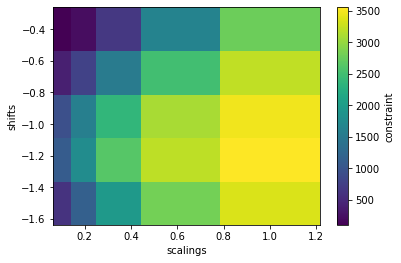

In [6]:
erf_ds.constraint.sum("member").plot()

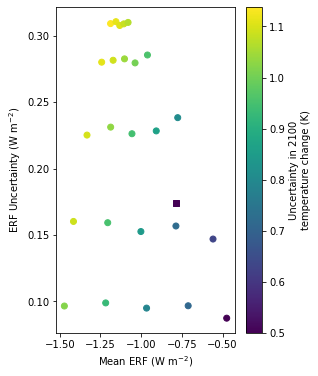

In [7]:
pl.figure(figsize=(4,6))
erf_ds.plot.scatter('Mean ERF', 'ERF Uncertainty', hue='Uncertainty in 2100 temperature change (K)') #, cbar_kwargs=dict(orientation='horizontal'))
pl.setp(pl.gca(), xlabel='Mean ERF (W m$^{-2}$)', ylabel='ERF Uncertainty (W m$^{-2}$)')


pl.scatter(erf_da.where(aer_minus1_lb).mean('member'), erf_da.where(aer_minus1_lb).std('member'), c=t_2100_da.where(aer_minus1_lb).quantile([0.05, 0.95], 'member').diff('quantile'), marker='s')


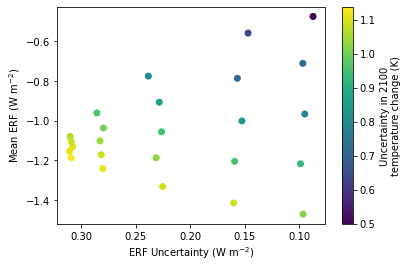

In [8]:
erf_ds.plot.scatter('ERF Uncertainty', 'Mean ERF', hue='Uncertainty in 2100 temperature change (K)')
pl.setp(pl.gca(), ylabel='Mean ERF (W m$^{-2}$)', xlabel='ERF Uncertainty (W m$^{-2}$)')
pl.gca().invert_xaxis()

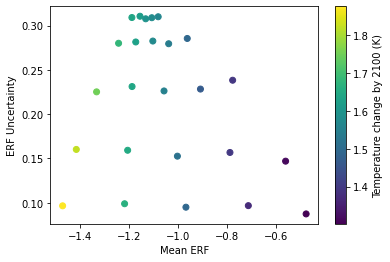

In [9]:
erf_ds.plot.scatter('Mean ERF', 'ERF Uncertainty', hue='Temperature change by 2100 (K)')

## Characterise by ECS

In [10]:
n_scalings = 5
n_shifts = 5
# scalings = np.linspace(0.1, 1., n_scalings)
scalings = np.logspace(0., -1., n_scalings)
scaling_corners = np.append(scalings - np.diff(scalings)[0]/2, scalings[-1] + np.diff(scalings)[0]/2)
shifts = np.logspace(np.log10(2), np.log10(4.6), n_shifts)
shift_corners = np.append(shifts - np.diff(shifts)[0]/2, shifts[-1] + np.diff(shifts)[0]/2)

In [11]:
from itertools import product

def _is_valid(shift_scale):
    shift, scale = shift_scale
    # Do a relative change in scale for ECS
    ecs_dist = st.norm(loc=shift, scale=scale*shift)
    return np.random.uniform(0., ecs_dist.pdf(ecs).max(), size=ecs.shape)<=ecs_dist.pdf(ecs)

res = np.asarray([x for x in map(_is_valid, product(shifts, scalings))])

ecs_constraint = xr.DataArray(data=res.reshape(n_shifts, n_scalings, -1),
                              coords=[('shifts', shifts), ('scalings', scalings), ('member', np.arange(n_ens))])

ds = xr.Dataset({'constraint': ecs_constraint, 'ECS': ecs_da, 
                'Mean ECS':ecs_da.where(ecs_constraint).mean('member'),
                'ECS Uncertainty':ecs_da.where(ecs_constraint).std('member'),
                 'Temperature change by 2050 (K)':t_2050_da.where(ecs_constraint).median('member'),
                 'Temperature change by 2100 (K)':t_2100_da.where(ecs_constraint).median('member'),
                'Uncertainty in 2100 temperature change (K)':t_2100_da.where(ecs_constraint).quantile([0.05, 0.95], 'member').diff('quantile')})
ds


<xarray.Dataset>
Dimensions:                                     (shifts: 5, scalings: 5, member: 3751, quantile: 1)
Coordinates:
  * shifts                                      (shifts) float64 2.0 ... 4.6
  * scalings                                    (scalings) float64 1.0 ... 0.1
  * member                                      (member) int64 0 1 ... 3749 3750
  * quantile                                    (quantile) float64 0.95
Data variables:
    constraint                                  (shifts, scalings, member) bool ...
    ECS                                         (member) float64 3.213 ... 2.482
    Mean ECS                                    (shifts, scalings) float64 2....
    ECS Uncertainty                             (shifts, scalings) float64 0....
    Temperature change by 2050 (K)              (shifts, scalings) float64 1....
    Temperature change by 2100 (K)              (shifts, scalings) float64 1....
    Uncertainty in 2100 temperature change (K)  (quantile, shifts, scalings) float64 ...

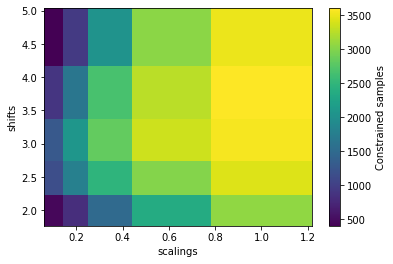

In [12]:
ds.constraint.sum("member").plot(cbar_kwargs=dict(label='Constrained samples'))

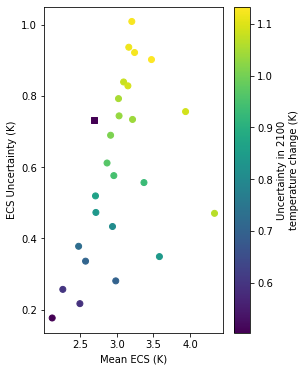

In [13]:
pl.figure(figsize=(4,6))
ds.plot.scatter('Mean ECS', 'ECS Uncertainty', hue='Uncertainty in 2100 temperature change (K)')
pl.setp(pl.gca(), xlabel='Mean ECS (K)', ylabel='ECS Uncertainty (K)')

pl.scatter(ecs_da.where(aer_minus1_lb).mean('member'), ecs_da.where(aer_minus1_lb).std('member'), c=t_2100_da.where(aer_minus1_lb).quantile([0.05, 0.95], 'member').diff('quantile'), marker='s')

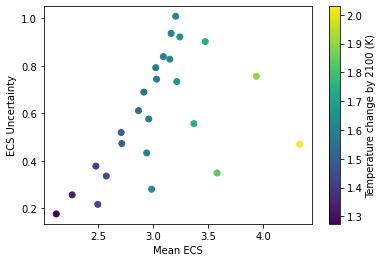

In [14]:
ds.plot.scatter('Mean ECS', 'ECS Uncertainty', hue='Temperature change by 2100 (K)')

## Direct comparison

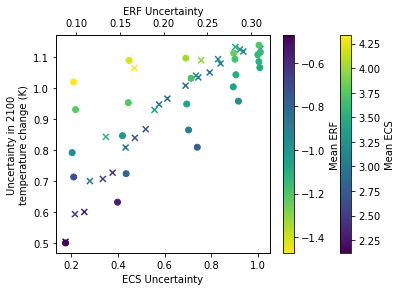

In [15]:
# This is OK but has a lot going on
ds.plot.scatter('ECS Uncertainty', 'Uncertainty in 2100 temperature change (K)', hue='Mean ECS', marker='x')
ax2 = pl.gca().twiny()
erf_ds.plot.scatter('ERF Uncertainty', 'Uncertainty in 2100 temperature change (K)', hue='Mean ERF', cmap='viridis_r')
# The fact that the ECS points are more densely sampled along the diagonal is due to the relative sampling 
#  we did (less sampling in the bottom right of the figure above as compared to the ERF)

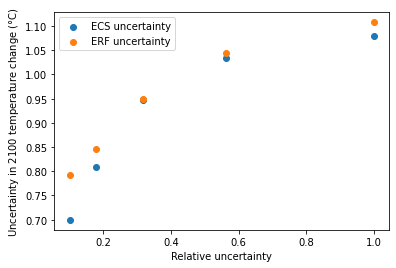

In [16]:
# Plot the average reduction in uncertainty across the different unrelying true values
pl.scatter(ds.scalings, ds['Uncertainty in 2100 temperature change (K)'].squeeze().median('shifts'), label='ECS uncertainty')
pl.scatter(erf_ds.scalings, erf_ds['Uncertainty in 2100 temperature change (K)'].squeeze().median('shifts'), label='ERF uncertainty')
# pl.scatter(erf_ds.scalings, erf_ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=3), label='ERF uncertainty')
pl.setp(pl.gca(), xlabel='Relative uncertainty', ylabel='Uncertainty in 2100 temperature change ($\degree$C)')
pl.legend()

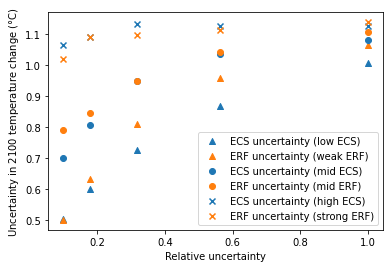

In [17]:
# Plot a selection of uncertainty reductions across the different unrelying true values
pl.scatter(ds.scalings, ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=0), label=f"ECS uncertainty (low ECS)", marker='^', c='tab:blue')
pl.scatter(erf_ds.scalings, erf_ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=4), label='ERF uncertainty (weak ERF)', marker='^', c='tab:orange')

pl.scatter(ds.scalings, ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=2), label=f"ECS uncertainty (mid ECS)", marker='o', c='tab:blue')
pl.scatter(erf_ds.scalings, erf_ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=2), label='ERF uncertainty (mid ERF)', marker='o', c='tab:orange')

pl.scatter(ds.scalings, ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=4), label=f"ECS uncertainty (high ECS)", marker='x', c='tab:blue')
pl.scatter(erf_ds.scalings, erf_ds['Uncertainty in 2100 temperature change (K)'].isel(shifts=0), label='ERF uncertainty (strong ERF)', marker='x', c='tab:orange')

pl.setp(pl.gca(), xlabel='Relative uncertainty', ylabel='Uncertainty in 2100 temperature change ($\degree$C)')
pl.legend()

## Make output data

In [18]:
mkdir_p('../data_output/')

In [19]:
erf_ds.to_netcdf('../data_output/erf_constraints_ssp126.nc')

In [20]:
ds.to_netcdf('../data_output/ecs_constraints_ssp126.nc')